# Train Deep Learning

In [49]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, regularizers
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout

In [50]:
df = pd.read_csv("../Data/new_train.csv")
df = df[df["nforest_type"] != "DEF"]

df["nforest_type"] = df["nforest_type"].map({'MDF': 0, 'DDF':1, 'DEF': 2})

In [51]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Get the counts of each class
# class_counts = Counter(df['nforest_type'])

# Separate features and target
X = df.drop(columns=['id','nforest_type'])
# X = df.drop(columns=['nforest_type'])
y = df['nforest_type']

# Instantiate the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Oversample the minority classes
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Split the oversampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.1, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,  random_state=42)

# Standardizing the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [52]:
X_train.shape

(10557, 200)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

tf.random.set_seed(34)
# build the model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='selu', input_shape=(25,)),
#     tf.keras.layers.Dropout(rate=0.075),
#     tf.keras.layers.Dense(128, activation='selu'),
#     tf.keras.layers.Dropout(rate=0.075),
#     tf.keras.layers.Dense(64, activation='selu'),
#     tf.keras.layers.Dropout(rate=0.075),
#     tf.keras.layers.Dense(64, activation='selu'),
#     tf.keras.layers.Dropout(rate=0.075),
#     tf.keras.layers.Dense(32, activation='selu'),
#     tf.keras.layers.Dropout(rate=0.075),
#     tf.keras.layers.Dense(16, activation='selu'),
#     tf.keras.layers.Dropout(rate=0.075),
#     tf.keras.layers.Dense(8, activation='selu'),
#     tf.keras.layers.Dropout(rate=0.075),
#     tf.keras.layers.Dense(3, activation='softmax')  # 3 units for 3 classes, softmax activation
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='selu', input_shape=(200,)),
    tf.keras.layers.Dropout(rate=0.075),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dropout(rate=0.075),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dropout(rate=0.075),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dropout(rate=0.075),
    tf.keras.layers.Dense(2, activation='softmax')  # 3 units for 3 classes, softmax activation
])

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='sparse_categorical_crossentropy',  # loss for multi-class classification
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=600, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/600
264/264 [==============================] - 1s 3ms/step - loss: 1.2410 - accuracy: 0.4896 - val_loss: 1.0194 - val_accuracy: 0.4848
Epoch 2/600
264/264 [==============================] - 1s 2ms/step - loss: 1.0202 - accuracy: 0.4947 - val_loss: 0.8269 - val_accuracy: 0.4948
Epoch 3/600
264/264 [==============================] - 1s 2ms/step - loss: 0.9211 - accuracy: 0.5138 - val_loss: 0.7600 - val_accuracy: 0.5161
Epoch 4/600
264/264 [==============================] - 1s 2ms/step - loss: 0.8949 - accuracy: 0.5185 - val_loss: 0.7337 - val_accuracy: 0.5450
Epoch 5/600
264/264 [==============================] - 1s 2ms/step - loss: 0.8619 - accuracy: 0.5330 - val_loss: 0.7187 - val_accuracy: 0.5668
Epoch 6/600
264/264 [==============================] - 1s 2ms/step - loss: 0.8650 - accuracy: 0.5336 - val_loss: 0.7084 - val_accuracy: 0.5852
Epoch 7/600
264/264 [==============================] - 1s 2ms/step - loss: 0.8468 - accuracy: 0.5451 - val_loss: 0.7007 - val_accuracy: 0.5985

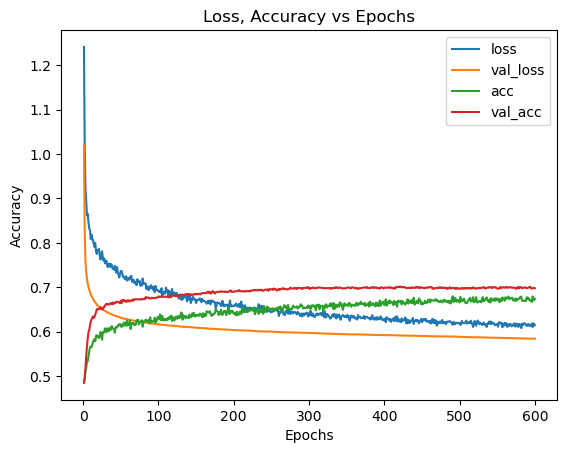

In [54]:
#plot the learning curves
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'], label = 'acc')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model.save("best_without_hyper.keras")

In [70]:
def build_model(hp):
    model = tf.keras.Sequential()

    # Add a dense layer with varying units
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_input', values=['selu', 'relu','elu']),
        input_shape=(147,),
    ))

    # Add dropout layers with varying rates
    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_1', min_value=0.01, max_value=0.3, step=0.01)
    ))

    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_2', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_input', values=['selu', 'relu','elu']),
        kernel_regularizer=tf.keras.regularizers.l1(hp.Float('l2_1', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_2', min_value=0.01, max_value=0.3, step=0.01)
    ))

    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_3', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_input', values=['selu', 'relu','elu']),
        kernel_regularizer=tf.keras.regularizers.l1(hp.Float('l2_2', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_3', min_value=0.01, max_value=0.3, step=0.01)
    ))

    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_4', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_input', values=['selu', 'relu','elu']),
        kernel_regularizer=tf.keras.regularizers.l1(hp.Float('l2_3', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_4', min_value=0.01, max_value=0.3, step=0.01)
    ))

    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_5', min_value=8, max_value=128, step=32),
        activation=hp.Choice('activation_input', values=['selu', 'relu','elu']),
        kernel_regularizer=tf.keras.regularizers.l1(hp.Float('l2_4', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_5', min_value=0.01, max_value=0.3, step=0.01)
    ))

    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_6', min_value=8, max_value=128, step=32),
        activation=hp.Choice('activation_input', values=['selu', 'relu','elu']),
        kernel_regularizer=tf.keras.regularizers.l1(hp.Float('l2_4', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_6', min_value=0.01, max_value=0.3, step=0.01)
    ))

    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_7', min_value=8, max_value=128, step=32),
        activation=hp.Choice('activation_input', values=['selu', 'relu','elu']),
        kernel_regularizer=tf.keras.regularizers.l1(hp.Float('l2_4', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_7', min_value=0.01, max_value=0.3, step=0.01)
    ))

    # Output layer for 3-class classification
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=5e-6, max_value=0.01)),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Hyper parameter tuning

In [71]:
import tensorflow as tf
from keras_tuner.tuners import Hyperband
from keras_tuner import HyperParameters

In [72]:
tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=600,
                  factor=3,
                  seed=34,
                  directory='my_hyperband_dir_final',
                  project_name='new_focus')



Reloading Tuner from my_hyperband_dir_final\new_focus\tuner0.json


In [73]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Get the counts of each class
class_counts = Counter(df['nforest_type'])

# Separate features and target
X = df.drop(columns=['id','nforest_type'])
y = df['nforest_type']

# Instantiate the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Oversample the minority classes
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)



# Standardizing the features
scaler = StandardScaler()
scaler.fit(X_oversampled)
X_oversampled = scaler.transform(X_oversampled)


In [ ]:
tuner.search(X_oversampled, y_oversampled, epochs=200, batch_size=128, validation_split=0.2, callbacks=[stop_early])

Trial 725 Complete [00h 00m 28s]
val_accuracy: 0.7931230664253235

Best val_accuracy So Far: 0.9195794463157654
Total elapsed time: 10h 33m 52s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("best_hyper_param_model_focus.keras")

d:\Coding\forest_hack\.env\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Coding\forest_hack\.env\myenv\Lib\site-packages\keras_tuner\src\tuners\hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
d:\Coding\forest_hack\.env\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping var

In [ ]:
import json

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Convert hyperparameters to a dictionary
best_hps_dict = best_hps.values

# Save the dictionary to a JSON file
with open('best_hyperparameters_focus.json', 'w') as f:
    json.dump(best_hps_dict, f)

In [ ]:
# plot the learning curves
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'], label = 'accuracy')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Loss, MAE vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006440372489359027,),
              loss='sparse_categorical_crossentropy',  # loss for multi-class classification
              metrics=['accuracy'])

best_model.fit(X_train, y_train, epochs=600, batch_size=128, validation_split=0.2, callbacks=[early_stopping])
history = best_model.fit(X_train, y_train, epochs=200, batch_size=512, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/600
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8172 - loss: 0.5465 - val_accuracy: 0.8693 - val_loss: 0.4356
Epoch 2/600
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8379 - loss: 0.5112 - val_accuracy: 0.8604 - val_loss: 0.4444
Epoch 3/600
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8275 - loss: 0.5168 - val_accuracy: 0.8579 - val_loss: 0.4455
Epoch 4/600
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8295 - loss: 0.5078 - val_accuracy: 0.8595 - val_loss: 0.4573
Epoch 5/600
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8325 - loss: 0.5027 - val_accuracy: 0.8639 - val_loss: 0.4463
Epoch 6/600
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8365 - loss: 0.5065 - val_accuracy: 0.8488 - val_loss: 0.4625
Epoch 7/600
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 0.5270 - val_accuracy: 0.8563 - val_loss: 0.4576
Epoch 8/600
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8371 - loss: 0.4937 - val_accuracy: 0.8573 - v

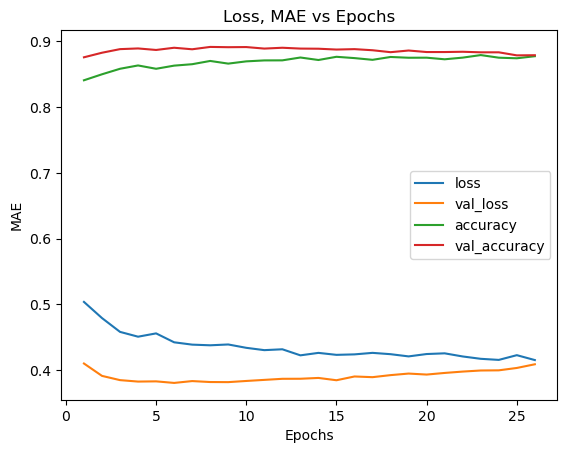

In [ ]:
# plot the learning curves
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'], label = 'accuracy')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Loss, MAE vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
test = pd.read_csv("../Data/focus_test.csv")
test = test[X.columns]
scaler.fit(test)
test_data = scaler.transform(test)

In [ ]:
test_data.shape

(4000, 147)

In [ ]:
best_model.save("best_hyper_param_model_tuned.keras")

In [ ]:
prediction=best_model.predict(test_data)
prediction = np.argmax(prediction, axis=1)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step


In [ ]:
prediction[:3]

array([2, 1, 0], dtype=int64)

In [ ]:
submission = pd.read_csv("../sample_submission.csv")
submission["nforest_type"] = prediction

In [ ]:
submission["nforest_type"] = submission["nforest_type"].map({0:'MDF', 1:'DDF', 2:'DEF'})

In [ ]:
submission["nforest_type"].value_counts()

nforest_type
MDF    1522
DDF    1272
DEF    1206
Name: count, dtype: int64

In [ ]:
submission.to_csv("Tenth_submission.csv", index=False)